# Import useful packages

In [80]:
import pandas as pd
from sklearn.cluster import KMeans

import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import svds
import pickle

from sklearn.neighbors import NearestNeighbors

# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
from sklearn.cross_validation import train_test_split

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

# Bring in key features / labels

In [3]:
#################### Pulling in the Lookup Table for Movies #############################

lookup_table_movies = pd.read_pickle('lookup_table_movies.pickle')

#################### Pulling in the User Ratings #############################

user_ratings = pd.read_pickle('user_ratings.pickle')

# This contains all the movieIDs for which we have already compiled metadata info available (i.e. from hetrec)
movies_with_metadata = lookup_table_movies["movieID"].unique()  #10197 in length

# This takes all the user ratings from the ml-latest download, and pairs it down to only those movies 
# for which we have metadata information.
user_ratings_for_movies_with_metadata = user_ratings[user_ratings["movieID"].isin(movies_with_metadata)] # 10196 in length


#################### Pulling in the Movie - X Feature Candidates #############################
imdb_and_rt_ratings_feature = pd.read_pickle('imdb_and_rt_ratings_feature.pickle') #<- ??Maybe I should consider dim. reducing these too?
misc_movie_features = pd.read_pickle('misc_movie_features.pickle')

#This is the full genre dummy feature... seems like perhaps I could test it whole since it's relatively small
genre_feature_dummied = pd.read_pickle('genre_feature_dummied.pickle')

#This is the svd shrunk features.
directors_feature_dim_reduced = pd.read_pickle('directors_feature_dim_reduced.pickle')
genre_feature_dim_reduced = pd.read_pickle('genre_feature_dim_reduced.pickle')
tags_feature_dim_reduced= pd.read_pickle('tags_feature_dim_reduced.pickle')
actors_feature_dim_reduced = pd.read_pickle('actors_feature_dim_reduced.pickle')

In [ ]:
# Let's do some basic visualization...

In [8]:
user_ratings_for_movies_with_metadata["binary_rating"] = 0
# Going to try to make this into a binary variable... where scores 3 and above go to 1, and scores less than that go to 0.
user_ratings_for_movies_with_metadata.loc[user_ratings_for_movies_with_metadata['rating'] >= 3, 'binary_rating'] = 1

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [20]:
print user_ratings_for_movies_with_metadata.shape
user_ratings_for_movies_with_metadata.head()

(21359520, 4)


,userID,movieID,rating,binary_rating
0,1,169,2.5,0
1,1,2471,3.0,1
2,1,48516,5.0,1
3,2,2571,3.5,1
7,3,356,4.0,1


In [45]:
# Generate a dataset and plot it
X = np.array(user_ratings_for_movies_with_metadata[["userID","movieID"]].tail(500))
y = np.array(user_ratings_for_movies_with_metadata["binary_rating"].tail(500))

<function matplotlib.pyplot.legend>

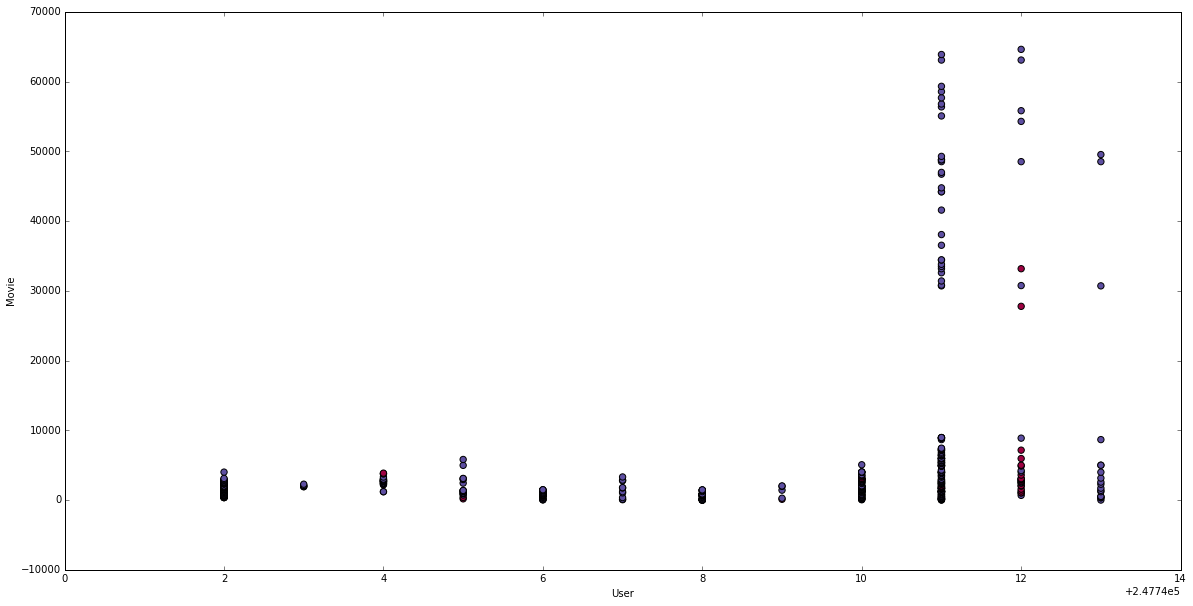

In [46]:
plt.scatter(X[:,0], X[:,1], c = y, s=40, cmap=plt.cm.Spectral)
plt.xlabel("User")
plt.ylabel("Movie")
plt.legend

# Implementing a Neural Network from scratch.
Using this as a baseline:http://localhost:8888/notebooks/Metis/WorkInProgressMetis/Neural%20Networks%20Playground%20/nn-from-scratch-master/nn-from-scratch.ipynb


In [ ]:
del user_ratings_for_movies_with_metadata["rating"]

,userID,movieID,binary_rating
0,1,169,0
1,1,2471,1
2,1,48516,1
3,2,2571,1
7,3,356,1


In [94]:
All_data = pd.merge(user_ratings_for_movies_with_metadata, genre_feature_dim_reduced, on = "movieID")
print All_data.shape
All_data.head()
y = All_data["binary_rating"]
X = All_data.drop(['binary_rating', "rating"], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.5)
print X_train.shape
print y_train.shape
print 
print X_test.shape
print y_test.shape

(21359520, 13)
(10679760, 12)
(10679760,)

(10679760, 12)
(10679760,)


In [95]:
X = X_train
y = y_train

In [96]:
num_examples = len(X) # training set size
nn_input_dim = 12 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

In [97]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [98]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [99]:
# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

In [100]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=2000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))        #These used to be 1?
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))  #These used to be 1?

    # This is what we return at the end
    model = {}
    
    # Gradient descent parameters (I picked these by hand)
    epsilon = 0.01 # learning rate for gradient descent
    reg_lambda = 0.01 # regularization strength
    
    # Gradient descent. For each batch...
    for i in xrange(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 100 == 0:
          print "Loss after iteration %i: %f" %(i, calculate_loss(model))
    
    return model

In [101]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

ValueError: Shape of passed values is (3, 1), indices imply (3, 10679760)